In [1]:
#Establecer directorio
cd("$(homedir())/Documents/UNAM/Tesis_Lic")

In [2]:
using StatsBase

In [3]:
using DelimitedFiles

In [4]:
using RandomNumbers.Xorshifts

In [5]:
using LightGraphs

In [6]:
using Plots

In [7]:
"""
    import_matrix(arch::AbstractString)

Función que importa el archivo de la matriz de adyacencia de R.
"""
function import_matrix(arch::AbstractString)
    archivo_R = readdlm(arch, ',') 
    archivo_R = archivo_R[2:end, :]
    matriz = archivo_R[:, 2:end]
    nombre = convert(Array{Int64,2}, matriz)
    return nombre
end

import_matrix

In [8]:
"""
    airport_names(arch::AbstractString)

Función que obtiene un arreglo con los nombres de aeropuertos de la matriz
"""
function airport_names(arch::AbstractString)
    archivo_R = readdlm(arch, ',', String)
    columna = archivo_R[1, :]
    nombres = columna[2:end]
    return nombres
end

airport_names

In [9]:
"""
    neighbours(M::Array{Int64,2})

Función que obtiene un conjunto de arreglos con los vecinos de cada nodo.
"""
function neighbours(M::Array{Int64,2})
    
    nodos = size(M, 1) #aeropuertos
    vecindades = []
    
    for i in 1:nodos
        vecinos = findall(x -> x != 0, M[i, :])
        push!(vecindades, vecinos)
    end
    vecindades
end

neighbours

In [10]:
"""

    r_walks(M::Array{Int64,2}, f::Int64, steps::Int64, iter::Int64)

La función r_walks tiene como parámetros:
M, matriz de adyacencia de tipo Array{Int64,2}
f, nodo inicial de tipo Int64
steps, número de pasos de tipo Int64
iter, número de iteraciones de tipo Int64.
La función crea un caminante aleatorio sobre la matriz, el cual tiene igual probabilidad de avanzar 
hacia cualquiera de sus vecinos.
Regresa un arreglo que contiene todas las trayectorias que tomó el caminante aleatorio.
"""
function r_walks(M::Array{Int64,2}, f::Int64, steps::Int64, iter::Int64)
    
    paths = zeros(Int64, (iter, steps + 1))
    s = f
    seed = 1
    vecindades = neighbours(M)

    for i in 1:iter
        paths[i, 1] = f
        
        for p in 1:steps 
            vecindad = vecindades[s]
            
            if vecindad == []
                break
            else
                a = sample(Xoroshiro128Plus(seed), vecindad) 
                paths[i, p + 1] = a
                s = a
                seed += 1
            end
            
        end
        s = f
        
    end
    
    return paths 
end

r_walks

In [11]:
"""

    random_walk(M::Array{Int64,2}, steps::Int64, iter::Int64)

La función random_walk tiene como parámetros:
M, matriz de adyacencia de tipo Array{Int64,2}
steps, número de pasos de tipo Int64
iter, número de iteraciones de tipo Int64.
La función crea un caminante aleatorio sobre la matriz con igual probabilidad de avanzar 
hacia cualquiera de sus vecinos. Esta función recorre todos los nodos de la red como
nodos iniciales y sobre ellos itera para obtener el número de caminos que se le pidió.
Regresa un arreglo que contiene arreglos asociados a todas las trayectorias que tomó el 
caminante aleatorio para cada nodo inicial de la red.
"""
function random_walk(M::Array{Int64,2}, steps::Int64, iter::Int64) 
    
    random_walks = []
    nodos = size(M, 1)
    
    for f in 1:nodos #aeropuertos
        paths = r_walks(M, f, steps, iter)
        push!(random_walks, paths)
    end
    
    random_walks
end

random_walk

In [12]:
"""
    visited_vertices(W::Array{Any,1})

La función caminos tiene como parámetro W que es un arreglo de arreglos.
Regresa los nodos diferentes a los que llega el caminante.
"""
function visited_vertices(W::Array{Any,1})
    
    cobert = []
    v = length(W) #tamaño de la matriz, número de nodos
    s = size(W[1], 1) #lo puedo sacar, para todos es el mismo. Es el número de iteraciones
    t = size(W[1], 2) #número de pasos, no necesario
    #visit = zeros(Int64, s) #Arreglo de ceros de tamaño número de iteraciones
    visit = []
    
    for i in 1:v        
        for j in 1:s
            u = unique(W[i][j, :])
            push!(visit, u)
        end
        
        push!(cobert, visit)
        visit = []
    end
    
    return cobert
end

visited_vertices

In [13]:
"""
    walk_global(W::Array{Any,1}, airline_code::String, v::Int64)

Función que cambia las caminatas del número de nodo asociado a la aerolínea a número de nodo GLOBAL de aeropuertos.
Parámetros:
W = caminatas aleatorias (arreglo de matrices)
airline_code = código de la aerolínea
v = nodo inicial
"""
function walk_global(W::Array{Any,1}, airline_code::String, v::Int64)
    
    #Primero se lee el archivo con las caminatas
    #path = string("/Users/yuriko/Downloads/codejulia/data/",airline_code,"/",airline_code,"_",v,"_random_walk.csv")
    #W = readdlm("/Users/yuriko/Downloads/codejulia/data/2B/caminatas/2B_1_random_walk.csv", ',', Int64) 
    
    #Ahora se usa la función para obtener los nodos diferentes
    nodos_diferentes = visited_vertices(W)
    #vv2b[1][1,:] #Nodos únicos visitados en la iteración 1 con nodo inicial 1 #Leo los visited vertices del archivo
    m = size(W[1], 1) #renglones
    n = size(W[1], 2) #columnas
    l = length(W) #número de nodos iniciales
    
    #Se lee el diccionario
    archivo_dicc = readdlm("/Users/yuriko/Documents/UNAM/Tesis_Lic/data/diccionarios/dictionary_final.csv", ',') 
    
    aerol_col = string(airline_code, "_num") #Nombre de la columna
    coord_aerol = findall(x -> x == aerol_col, archivo_dicc) #Busco las coordenadas de la columna
    col_aerol = coord_aerol[1][2] #Segunda coordenada de la posición (columna)
    columna_aerol = archivo_dicc[:, col_aerol] #Obtengo la columna con el nombre del aeropuerto al que corresponde
    
    for k = v #1:l #nodo inicial v
        arreglo_visitas = nodos_diferentes[k]
        caminatas_nodo = W[k]
        walk_empty = zeros(Int64, m, n)#Arreglo vacío para nuevos números
        
        for i in 1:m #voy por las iteraciones
            nodos_dif = arreglo_visitas[i, :] #array/caminata única de los nodos que buscará
            
            for j in 1:length(nodos_dif[])
                nodo_original = nodos_dif[][j]
                #Busco la posición original del aeropuerto que se asignará
                posicion_original = findall(x -> x == nodo_original, archivo_dicc[:, col_aerol])
                #Se busca el nombre del aeropuerto
                numero_asignado = archivo_dicc[posicion_original, 3]
                #Busco el primer nodo diferente en la iteración i
                coords_ys = findall(x -> x == nodo_original, caminatas_nodo[i, :]) #Encuentra uno de los nodos dif en la iteración
                
                for q in 1:length(coords_ys) #Se itera sobre las posiciones en las caminatas
                    pos_actual = coords_ys[q]
                    #nodo_original = findall(x -> x == pos_actual, columna_aerol) #buscar el nodo en la aerolínea
                    #aerop_nombre = nodo_original[1]+1
                    #aeropuerto_asignado = archivo_dicc[nodos_dif[i],2]#nodo_original, 2] #buscando qué nombre se colocará
                    walk_empty[i, pos_actual] = numero_asignado[] #asigno valor de diccionario al arreglo vacío i, pos_actual
                end
            end

        end

        return walk_empty
        
    end
    
end

walk_global

In [14]:
"""
    walk_names(W::Array{Any,1}, airline_code::String, v::Int64)

Función que cambia las caminatas del número de nodo asociado a la aerolínea a nombres de aeropuertos.
Parámetros:
W = caminatas aleatorias (arreglo de matrices)
airline_code = código de la aerolínea
v = nodo inicial
"""
function walk_names(W::Array{Any,1}, airline_code::String, v::Int64) 
    
    #Primero se lee el archivo con las caminatas
    #path = string("/Users/yuriko/Downloads/codejulia/data/",airline_code,"/",airline_code,"_",v,"_random_walk.csv")
    #W = readdlm("/Users/yuriko/Downloads/codejulia/data/2B/caminatas/2B_1_random_walk.csv", ',', Int64) 
    
    #Ahora se usa la función para obtener los nodos diferentes
    nodos_diferentes = visited_vertices(W)
    #vv2b[1][1,:] #Nodos únicos visitados en la iteración 1 con nodo inicial 1 #Leo los visited vertices del archivo
    m = size(W[1], 1) #renglones
    n = size(W[1], 2) #columnas
    l = length(W) #número de nodos iniciales
    
    #Se lee el diccionario
    archivo_dicc = readdlm("/Users/yuriko/Documents/UNAM/Tesis_Lic/data/diccionarios/dictionary_final.csv", ',') 
    
    aerol_col = string(airline_code, "_num") #Nombre de la columna
    coord_aerol = findall(x -> x == aerol_col, archivo_dicc) #Busco las coordenadas de la columna
    col_aerol = coord_aerol[1][2] #Segunda coordenada de la posición (columna)
    columna_aerol = archivo_dicc[:, col_aerol] #Obtengo la columna con el nombre del aeropuerto al que corresponde
    
    for k = v #1:l #nodo inicial v
        arreglo_visitas = nodos_diferentes[k]
        caminatas_nodo = W[k]
        walk_nothing = Array{Union{Nothing, String}}(nothing, m, n) #archivo vacío de una matriz para un nodo inicial
        
        for i in 1:m #voy por las iteraciones
            nodos_dif = arreglo_visitas[i, :] #array/caminata única de los nodos que buscará
            
            for j in 1:length(nodos_dif[])
                nodo_original = nodos_dif[][j]
                #Busco la posición original del aeropuerto que se asignará
                posicion_original = findall(x -> x == nodo_original, archivo_dicc[:, col_aerol])
                #Se busca el nombre del aeropuerto
                nombre_asignado = archivo_dicc[posicion_original, 2]
                #Busco el primer nodo diferente en la iteración i
                coords_ys = findall(x -> x == nodo_original, caminatas_nodo[i, :]) #Encuentra uno de los nodos dif en la iteración
                
                for q in 1:length(coords_ys) #Se itera sobre las posiciones en las caminatas
                    pos_actual = coords_ys[q]
                    #nodo_original = findall(x -> x == pos_actual, columna_aerol) #buscar el nodo en la aerolínea
                    #aerop_nombre = nodo_original[1]+1
                    #aeropuerto_asignado = archivo_dicc[nodos_dif[i],2]#nodo_original, 2] #buscando qué nombre se colocará
                    walk_nothing[i, pos_actual] = nombre_asignado[] #asigno valor de diccionario al arreglo vacío i, pos_actual
                end
            end

        end

        return walk_nothing
        
    end
    
end

walk_names

In [15]:
"""
    walk_length(W::Array{Any,1})

La función walk_length tiene como parámetros:
RW, arreglo de arreglos de tipo Array{Any,1} que corresponde al arreglo de caminatas aleatorias.
La función regresa un arreglo de arreglos que contiene las longitudes de todas las trayectorias que tomó el 
caminante aleatorio para cada nodo inicial de la red.
"""
function walk_length(W::Array{Any,1})
    
    longitudes = Array[]
    
    v = length(W) #tamaño de la matriz, número de nodos
    s = size(W[1], 1) #Es el número de iteraciones
    longitud = zeros(Int64, s)
    
    for i in 1:v
        
        for j in 1:s
               
            longitud[j] = findlast(x -> x != 0, W[i][j, :])
            
        end
         push!(longitudes, longitud)
        
        longitud = zeros(Int64, s)
    end
    return longitudes
        
end

walk_length

In [16]:
"""
    walk_av_length(W::Array{Any,1})

La función walk_av_length tiene como parámetro W, que es un arreglo de arreglos (que se puede obtener de la 
función walk_length). 
Regresa un arreglo con entradas correspondientes al promedio de las longitudes de 
las caminatas aleatorias para cada nodo de inicio antes de caer en un nodo con grado de salida 0.
"""
function walk_av_length(W::Array{Any,1}) #Llamar a función
    
    proms = Array{Float64}(undef, 0)
    wlength = walk_length(W)
    
    for i in 1:length(wlength)
        av = mean(wlength[i])
        push!(proms, av)
    end
    proms
end

walk_av_length

In [82]:
"""
    plot_av_length_vertex(W::Array{Float64, 1}, airline_code::String)

Función que grafica (scatter plot) del promedio por nodo inicial de caminatas
"""
function plot_av_length_vertex(W::Array{Any,1}, airline_code::String)

    pyplot()

    info = walk_av_length(W)
    aerolinea_matriz = string(airline_code, "_matriz_du.csv")
    nombres_multiplex = airport_names("/Users/yuriko/Documents/UNAM/Tesis_Lic/data/aerolineas_matrices/$aerolinea_matriz")

    scatter(info,
        color = "#0f87bf",
        alpha = 0.8,
        title = string("Longitud promedio por nodo de ",airline_code),
        xticks = (1:1:length(W), nombres_multiplex), #data_names_multiplex),
        xlabel = "Aeropuerto inicial",
        ylabel = "Longitud",
        legendtitle = airline_code,
        label = "Promedio",
        xrotation = 50,
        ylims = (0, 500))
end

plot_av_length_vertex

In [18]:
"""
    distrib_av_visits(W::Array{Any, 1})

Función que hace una distribución de visitas por nodo inicial y muestra todos los nodos iniciales
"""
function distrib_av_visits(W::Array{Any, 1}) 
    
    nodos = length(W) #número de nodos
    iteracion = size(W[1],1)
    dicc = zeros(Float64, nodos, nodos+1) #matriz de ceros (nodos x nodos+1)
    
    for i in 1:nodos #(1 a 17)
        prom_conteos = counts(W[i], 0:nodos)/iteracion #hago diccionario con prom de freqs de cada nodo inicial
        
        dicc[i, :] = prom_conteos 
    end

    dicc
end

distrib_av_visits

In [51]:
"""
    plot_freq_av_visits(W::Array{Any, 1})

Función que crea un diccionario con frecuencias por nodo inicial y muestra todos
"""
function plot_freq_av_visits(W::Array{Any, 1}, airline_code::String)

    pyplot()

    mat_completa = distrib_av_visits(W)
    mat = mat_completa[:, (2:end)] #desde la segunda columna para no tomar en cuenta los end-points

    aerolinea_matriz = string(airline_code, "_matriz_du.csv")
    nombres_multiplex = airport_names("/Users/yuriko/Documents/UNAM/Tesis_Lic/data/aerolineas_matrices/$aerolinea_matriz")

    xs = [nombres_multiplex]
    ys = [nombres_multiplex] #[string("v_0 ", i) for i = 1:length(W)]
    z = mat

    heatmap(xs, ys, z,
        title = string("Frecuencia de visitas para ", airline_code),
        aspect_ratio = 1,
        clims = (0, maximum(mat)), #MÁXIMO DEL MULTIPLEX GLOBAL/AEROLÍNEA MÁS GRANDE ¿?
        xticks = :all,
        yticks = :all,
        xtickfont = font(7), #"Arial"),
        ytickfont = font(7), #"Courier"),
        ylabel = "Visitas promedio",
        xlabel = "Aeropuerto inicial",
        xrotation = 50)
end

plot_freq_av_visits

In [20]:
"""
    coverage(W::Array{Any,1})

La función cobertura tiene como parámetro W que es un arreglo de arreglos.
Regresa el número de nodos diferentes a los que llega el caminante.
"""
function coverage(W::Array{Any,1}) 
    
    cobert = []
    
    v = length(W) #tamaño de la matriz, número de nodos
    x = visited_vertices(W)
    s = size(x[1], 1) #lo puedo sacar, para todos es el mismo. Es el número de iteraciones
    longz = zeros(Int64, s) #Arreglo de ceros de tamaño número de iteraciones
    
    for i in 1:v        
        for j in 1:s
            l = length(x[i][j])
            longz[j] = l
        end
        
        push!(cobert, longz)
        longz = zeros(Int64, s)
    end
    
    return cobert
end

coverage

In [21]:
"""
    vertex_coverage(W::Array{Any,1})

Da el promedio de cobertura la caminata por nodo inicial. 
"""
function vertex_coverage(W::Array{Any,1}) #Esta es la importante
    
    longitud = Array{Float64}(undef, 0)
    x = coverage(W)
    
    for i in 1:length(x)
        l = mean(x[i])
        push!(longitud, l)
    end
    
    longitud
end

vertex_coverage

In [80]:
"""
    plot_vertex_coverage(W::Array{Any, 1}, airline_code::String)

Función que grafica (scatter plot) del promedio por nodo inicial de caminatas
"""
function plot_vertex_coverage(W::Array{Any, 1}, airline_code::String)

    info = vertex_coverage(W)

    aerolinea_matriz = string(airline_code, "_matriz_du.csv")
    nombres_multiplex = airport_names("/Users/yuriko/Documents/UNAM/Tesis_Lic/data/aerolineas_matrices/$aerolinea_matriz")


    scatter(info,
        color = "#0f87bf",
        alpha = 0.4,
        title = string("Cobertura por nodo inicial ", airline_code),
        xlabel = "Aeropuerto inicial",
        ylabel = "Longitud",
        xticks = (1:1:length(W), nombres_multiplex),
        yticks =:all,
        legendtitle = airline_code,
        label = "Promedio",
        xrotation = 50,
        #xlims = (-10,300)) #obtener límites
        ylims = (0, 50))

end


plot_vertex_coverage

In [40]:
archivo_dicc = readdlm("/Users/yuriko/Documents/UNAM/Tesis_Lic/data/diccionarios/dictionary_final.csv", ',')

3190×570 Array{Any,2}:
     ""  "global_airports"  …  "ZK_num"  "ZL_num"   "ZM_num"
    1    "AER"                 "NA"      "NA"       "NA"    
    2    "ASF"                 "NA"      "NA"       "NA"    
    3    "CEK"                 "NA"      "NA"       "NA"    
    4    "DME"                 "NA"      "NA"      1        
    5    "EGO"              …  "NA"      "NA"       "NA"    
    6    "GYD"                 "NA"      "NA"       "NA"    
    7    "KGD"                 "NA"      "NA"       "NA"    
    8    "KZN"                 "NA"      "NA"       "NA"    
    9    "LED"                 "NA"      "NA"       "NA"    
   10    "MRV"              …  "NA"      "NA"       "NA"    
   11    "NBC"                 "NA"      "NA"       "NA"    
   12    "NJC"                 "NA"      "NA"       "NA"    
    ⋮                       ⋱                               
 3178    "LPS"                 "NA"      "NA"       "NA"    
 3179    "ORX"                 "NA"      "NA"       "NA"    
 

In [43]:
archivo_dicc[:,3]

3190-element Array{Any,1}:
     "global_num"
    1            
    2            
    3            
    4            
    5            
    6            
    7            
    8            
    9            
   10            
   11            
   12            
    ⋮            
 3178            
 3179            
 3180            
 3181            
 3182            
 3183            
 3184            
 3185            
 3186            
 3187            
 3188            
 3189            

In [23]:
lista_aerolineas = readdlm("/Users/yuriko/Documents/UNAM/Tesis_Lic/data/aerolineas_matrices/lista_aerolineas.csv", ',', String)
airline_code = lista_aerolineas[2]

"2B"

In [85]:
lista_aerolineas

568×2 Array{String,2}:
 ""    "Airline"
 "2B"  "2B"     
 "2G"  "2G"     
 "2I"  "2I"     
 "2J"  "2J"     
 "2K"  "2K"     
 "2L"  "2L"     
 "2N"  "2N"     
 "2O"  "2O"     
 "2P"  "2P"     
 "2Z"  "2Z"     
 "3E"  "3E"     
 "3F"  "3F"     
 ⋮              
 "Z3"  "Z3"     
 "Z4"  "Z4"     
 "Z8"  "Z8"     
 "Z9"  "Z9"     
 "ZB"  "ZB"     
 "ZD"  "ZD"     
 "ZE"  "ZE"     
 "ZH"  "ZH"     
 "ZI"  "ZI"     
 "ZK"  "ZK"     
 "ZL"  "ZL"     
 "ZM"  "ZM"     

In [24]:
aerolinea_matriz = string(airline_code, "_matriz_du.csv")
multiplex = import_matrix("data/aerolineas_matrices/$aerolinea_matriz")

17×17 Array{Int64,2}:
 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  1  0  0  1  0  0  0  0  1  1
 0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  0  0  0  1  0  0  0  0  0  1  0  0
 0  0  0  0  0  0  0  1  0  0  1  0  0  0  0  0  1
 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  1  0  0  1  0  0  0  0  0  1  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
 0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0  0
 0  0  0  0  0  0  0  1  0  0  1  1  1  1  0  0  0
 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  1  0  0  1  0  0  0  0  0

In [25]:
data_names_multiplex = airport_names("data/aerolineas_matrices/$aerolinea_matriz")

17-element Array{String,1}:
 "AER"
 "ASF"
 "CEK"
 "DME"
 "EGO"
 "GYD"
 "KGD"
 "KZN"
 "LED"
 "MRV"
 "NBC"
 "NJC"
 "NUX"
 "OVB"
 "SVX"
 "TGK"
 "UUA"

In [26]:
vecinos_M = @time neighbours(multiplex)

  0.100243 seconds (205.44 k allocations: 9.861 MiB)


17-element Array{Any,1}:
 [8]                   
 [8, 10]               
 [8, 14]               
 [8, 11, 16, 17]       
 [7, 8]                
 [11]                  
 [5]                   
 [1, 2, 3, 4, 5, 9, 15]
 [8, 11, 17]           
 [2]                   
 [4, 6, 9, 15]         
 [15, 17]              
 [15]                  
 [3, 15]               
 [8, 11, 12, 13, 14]   
 [4]                   
 [4, 9, 12]            

In [27]:
caminata_M = @time random_walk(multiplex, 50, 10) #nuevo

  0.186624 seconds (441.51 k allocations: 22.674 MiB, 4.78% gc time)


17-element Array{Any,1}:
 [1 8 … 4 8; 1 8 … 4 8; … ; 1 8 … 12 15; 1 8 … 9 11]        
 [2 10 … 4 8; 2 10 … 4 8; … ; 2 10 … 12 15; 2 10 … 9 11]    
 [3 14 … 4 8; 3 14 … 4 8; … ; 3 14 … 12 15; 3 14 … 9 11]    
 [4 11 … 4 8; 4 11 … 4 8; … ; 4 17 … 12 15; 4 17 … 9 11]    
 [5 8 … 4 8; 5 8 … 4 8; … ; 5 8 … 12 15; 5 8 … 9 11]        
 [6 11 … 4 8; 6 11 … 4 8; … ; 6 11 … 12 15; 6 11 … 9 11]    
 [7 5 … 4 8; 7 5 … 4 8; … ; 7 5 … 9 17; 7 5 … 9 11]         
 [8 9 … 4 8; 8 15 … 4 8; … ; 8 4 … 9 17; 8 1 … 9 11]        
 [9 17 … 4 8; 9 17 … 4 8; … ; 9 17 … 12 15; 9 11 … 9 11]    
 [10 2 … 4 8; 10 2 … 4 8; … ; 10 2 … 9 17; 10 2 … 9 11]     
 [11 6 … 4 8; 11 6 … 4 8; … ; 11 15 … 12 15; 11 15 … 9 11]  
 [12 17 … 4 8; 12 17 … 4 8; … ; 12 17 … 12 15; 12 17 … 9 11]
 [13 15 … 4 8; 13 15 … 4 8; … ; 13 15 … 12 15; 13 15 … 9 11]
 [14 15 … 4 8; 14 15 … 4 8; … ; 14 15 … 12 15; 14 15 … 9 11]
 [15 11 … 4 8; 15 8 … 4 8; … ; 15 11 … 12 15; 15 11 … 9 11] 
 [16 4 … 4 8; 16 4 … 4 8; … ; 16 4 … 9 17; 16 4 … 9 11]     

In [39]:
caminata_M[1]

10×51 Array{Int64,2}:
 1  8   4  17  12  17   4  17  12  15  …  14   3  14   3  14   3   8   4   8
 1  8   2  10   2  10   2   8   5   7     11   4  11   9   8   9  17   4   8
 1  8   9  17  12  15   8  15   8   4     11   4  16   4   8   1   8   2   8
 1  8   9  11   6  11  15  11   6  11      8  15  13  15  12  17   4  17  12
 1  8   3   8   5   7   5   7   5   8      8  15  13  15  12  17  12  15  13
 1  8  15  14  15  13  15  13  15   8  …   7   5   7   5   8   2  10   2  10
 1  8   3   8   2  10   2  10   2  10      7   5   8   1   8   3  14   3  14
 1  8   4  11   9   8   3  14   3  14     15  11  15  13  15  14  15  11   9
 1  8   2  10   2  10   2  10   2   8      3   8   4   8  15  13  15  12  15
 1  8   5   8  15  14  15  14  15  13     15  12  17   9   8   4   8   9  11

In [28]:
li_M = @time walk_length(caminata_M)

  0.098353 seconds (201.93 k allocations: 9.796 MiB)


17-element Array{Array,1}:
 [51, 51, 51, 51, 51, 51, 51, 51, 51, 51]
 [51, 51, 51, 51, 51, 51, 51, 51, 51, 51]
 [51, 51, 51, 51, 51, 51, 51, 51, 51, 51]
 [51, 51, 51, 51, 51, 51, 51, 51, 51, 51]
 [51, 51, 51, 51, 51, 51, 51, 51, 51, 51]
 [51, 51, 51, 51, 51, 51, 51, 51, 51, 51]
 [51, 51, 51, 51, 51, 51, 51, 51, 51, 51]
 [51, 51, 51, 51, 51, 51, 51, 51, 51, 51]
 [51, 51, 51, 51, 51, 51, 51, 51, 51, 51]
 [51, 51, 51, 51, 51, 51, 51, 51, 51, 51]
 [51, 51, 51, 51, 51, 51, 51, 51, 51, 51]
 [51, 51, 51, 51, 51, 51, 51, 51, 51, 51]
 [51, 51, 51, 51, 51, 51, 51, 51, 51, 51]
 [51, 51, 51, 51, 51, 51, 51, 51, 51, 51]
 [51, 51, 51, 51, 51, 51, 51, 51, 51, 51]
 [51, 51, 51, 51, 51, 51, 51, 51, 51, 51]
 [51, 51, 51, 51, 51, 51, 51, 51, 51, 51]

In [29]:
lpn_M = @time walk_av_length(caminata_M)

  0.083531 seconds (196.68 k allocations: 10.132 MiB)


17-element Array{Float64,1}:
 51.0
 51.0
 51.0
 51.0
 51.0
 51.0
 51.0
 51.0
 51.0
 51.0
 51.0
 51.0
 51.0
 51.0
 51.0
 51.0
 51.0

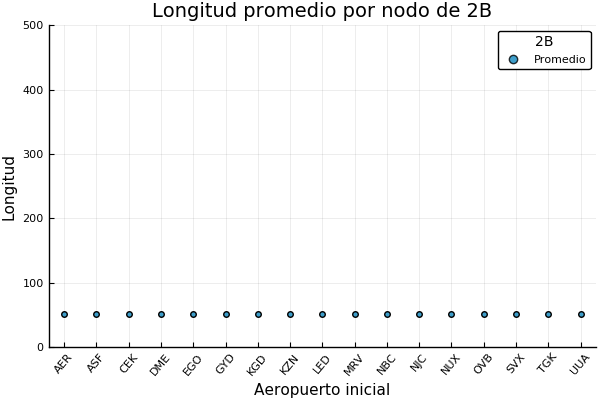

In [83]:
plot_av_length_vertex(caminata_M, "2B")

In [31]:
nv_M = @time visited_vertices(caminata_M)

  0.045186 seconds (52.29 k allocations: 2.789 MiB)


17-element Array{Any,1}:
 Any[[1, 8, 4, 17, 12, 15, 11, 9, 2, 5, 7, 3, 14], [1, 8, 2, 10, 5, 7, 15, 12, 17, 9, 11, 4, 16, 6], [1, 8, 9, 17, 12, 15, 4, 2, 16, 3, 14, 5, 7, 11], [1, 8, 9, 11, 6, 15, 4, 17, 12, 16, 3, 14, 13], [1, 8, 3, 5, 7, 15, 11, 9, 4, 6, 14, 13, 12, 17, 16], [1, 8, 15, 14, 13, 9, 11, 17, 4, 16, 3, 12, 5, 7, 2, 10], [1, 8, 3, 2, 10, 15, 14, 11, 6, 4, 9, 13, 12, 17, 16, 5, 7], [1, 8, 4, 11, 9, 3, 14, 15, 13, 12, 17, 16], [1, 8, 2, 10, 4, 16, 15, 13, 14, 11, 9, 17, 12, 3], [1, 8, 5, 15, 14, 13, 12, 17, 3, 11, 6, 4, 9]]          
 Any[[2, 10, 8, 3, 9, 4, 17, 14, 15, 12, 11, 1], [2, 10, 8, 5, 7, 1, 15, 12, 17, 9, 11, 4, 16, 6], [2, 10, 8, 9, 17, 4, 1, 3, 14, 15, 16, 11, 12, 13, 5, 7], [2, 10, 8, 3, 9, 14, 15, 11, 13, 4, 17, 12], [2, 8, 3, 5, 7, 15, 11, 9, 4, 6, 14, 13, 12, 17, 16], [2, 8, 15, 14, 13, 9, 11, 17, 4, 16, 1, 3, 12, 5, 7, 10], [2, 8, 3, 10, 15, 14, 11, 6, 4, 9, 13, 12, 17, 16, 1, 5, 7], [2, 8, 4, 11, 9, 3, 14, 15, 13, 12, 17, 16], [2, 10, 8, 4, 16, 1, 15, 13, 

In [44]:
@time walk_global(caminata_M, "2B", 1)

  1.597480 seconds (13.47 M allocations: 483.622 MiB, 42.04% gc time)


10×51 Array{Int64,2}:
 1  8   4  17  12  17   4  17  12  15  …  14   3  14   3  14   3   8   4   8
 1  8   2  10   2  10   2   8   5   7     11   4  11   9   8   9  17   4   8
 1  8   9  17  12  15   8  15   8   4     11   4  16   4   8   1   8   2   8
 1  8   9  11   6  11  15  11   6  11      8  15  13  15  12  17   4  17  12
 1  8   3   8   5   7   5   7   5   8      8  15  13  15  12  17  12  15  13
 1  8  15  14  15  13  15  13  15   8  …   7   5   7   5   8   2  10   2  10
 1  8   3   8   2  10   2  10   2  10      7   5   8   1   8   3  14   3  14
 1  8   4  11   9   8   3  14   3  14     15  11  15  13  15  14  15  11   9
 1  8   2  10   2  10   2  10   2   8      3   8   4   8  15  13  15  12  15
 1  8   5   8  15  14  15  14  15  13     15  12  17   9   8   4   8   9  11

In [45]:
@time walk_names(caminata_M, "2B", 1)

  2.092491 seconds (13.47 M allocations: 483.638 MiB, 67.79% gc time)


10×51 Array{Union{Nothing, String},2}:
 "AER"  "KZN"  "DME"  "UUA"  "NJC"  …  "OVB"  "CEK"  "KZN"  "DME"  "KZN"
 "AER"  "KZN"  "ASF"  "MRV"  "ASF"     "KZN"  "LED"  "UUA"  "DME"  "KZN"
 "AER"  "KZN"  "LED"  "UUA"  "NJC"     "KZN"  "AER"  "KZN"  "ASF"  "KZN"
 "AER"  "KZN"  "LED"  "NBC"  "GYD"     "NJC"  "UUA"  "DME"  "UUA"  "NJC"
 "AER"  "KZN"  "CEK"  "KZN"  "EGO"     "NJC"  "UUA"  "NJC"  "SVX"  "NUX"
 "AER"  "KZN"  "SVX"  "OVB"  "SVX"  …  "KZN"  "ASF"  "MRV"  "ASF"  "MRV"
 "AER"  "KZN"  "CEK"  "KZN"  "ASF"     "KZN"  "CEK"  "OVB"  "CEK"  "OVB"
 "AER"  "KZN"  "DME"  "NBC"  "LED"     "SVX"  "OVB"  "SVX"  "NBC"  "LED"
 "AER"  "KZN"  "ASF"  "MRV"  "ASF"     "SVX"  "NUX"  "SVX"  "NJC"  "SVX"
 "AER"  "KZN"  "EGO"  "KZN"  "SVX"     "KZN"  "DME"  "KZN"  "LED"  "NBC"

In [34]:
distrib_prom_M = @time distrib_av_visits(caminata_M)

  0.187578 seconds (540.47 k allocations: 27.372 MiB, 4.65% gc time)


17×18 Array{Float64,2}:
 0.0  1.9  2.4  3.5  4.8  2.2  0.7  1.4  …  4.7  2.3  1.6  3.7  5.9  0.9  2.6
 0.0  0.9  4.3  3.8  3.8  2.2  0.5  1.6     3.9  2.2  1.8  3.9  5.9  0.7  2.4
 0.0  0.8  1.4  7.2  3.6  1.9  0.4  1.1     3.1  2.4  2.1  6.9  6.7  0.8  2.3
 0.0  0.9  1.7  4.3  5.2  2.4  0.5  1.4     4.0  2.3  1.8  4.6  6.3  1.2  2.5
 0.0  1.2  2.0  3.3  4.5  4.4  0.6  2.3     4.3  2.3  1.5  3.4  5.7  0.8  2.4
 0.0  1.1  1.6  4.3  4.3  3.2  1.3  1.9  …  4.7  2.2  1.4  3.9  5.2  0.8  2.4
 0.0  2.0  1.7  5.9  4.2  5.7  0.2  4.2     2.9  0.4  0.4  4.6  2.5  0.8  0.8
 0.0  2.0  1.8  5.9  4.7  3.9  0.2  2.1     3.4  0.5  0.5  4.7  3.1  0.8  1.2
 0.0  1.0  2.0  5.4  4.1  2.3  0.3  1.4     3.3  2.2  1.5  5.0  5.5  0.8  2.8
 0.0  1.7  3.8  5.5  4.2  3.8  0.2  2.1     3.2  0.5  0.5  4.2  2.7  0.7  1.1
 0.0  1.7  1.9  4.8  4.0  3.7  0.6  2.1  …  4.3  1.4  1.1  4.2  4.8  0.8  1.2
 0.0  1.2  2.0  5.4  4.0  3.1  0.2  1.7     2.6  2.7  1.1  5.0  5.2  0.9  2.3
 0.0  1.3  2.0  4.7  4.2  3.4  0.2  1.9 

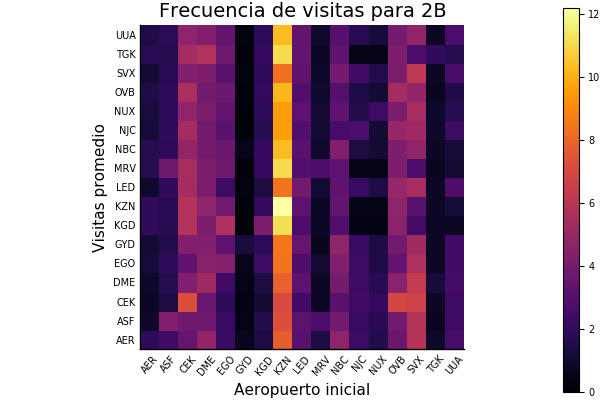

In [52]:
plot_freq_av_visits(caminata_M, "2B")

In [36]:
cobi_M = @time coverage(caminata_M)

  0.032565 seconds (22.11 k allocations: 1.345 MiB)


17-element Array{Any,1}:
 [13, 14, 14, 13, 15, 16, 17, 12, 14, 13]
 [12, 14, 16, 12, 15, 16, 17, 12, 14, 15]
 [11, 12, 15, 10, 14, 16, 17, 11, 15, 11]
 [11, 13, 14, 10, 14, 16, 17, 11, 15, 11]
 [13, 14, 14, 13, 14, 12, 13, 13, 15, 12]
 [12, 13, 15, 11, 16, 17, 14, 12, 16, 12]
 [12, 11, 13, 14, 11, 14, 12, 14, 11, 11]
 [12, 11, 13, 13, 12, 14, 12, 14, 11, 11]
 [11, 12, 14, 10, 15, 16, 17, 11, 15, 12]
 [13, 13, 13, 14, 11, 14, 14, 14, 13, 12]
 [13, 13, 13, 13, 12, 14, 12, 14, 15, 11]
 [11, 12, 14, 12, 14, 15, 13, 15, 15, 11]
 [14, 11, 13, 12, 15, 15, 13, 15, 15, 11]
 [13, 11, 12, 12, 11, 14, 12, 14, 16, 11]
 [11, 14, 15, 10, 15, 16, 13, 11, 15, 12]
 [13, 11, 11, 12, 13, 15, 12, 15, 12, 11]
 [12, 12, 12, 12, 12, 16, 12, 15, 15, 11]

In [37]:
cobs_M = @time vertex_coverage(caminata_M)

  0.015758 seconds (21.48 k allocations: 1.381 MiB)


17-element Array{Float64,1}:
 14.1
 14.3
 13.2
 13.2
 13.3
 13.8
 12.3
 12.3
 13.3
 13.1
 13.0
 13.2
 13.4
 12.6
 13.2
 12.5
 12.9

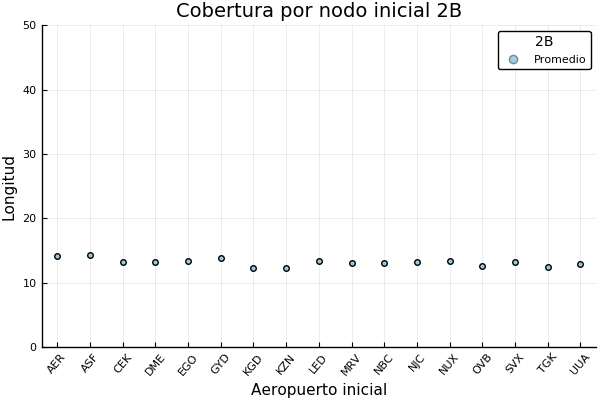

In [81]:
plot_vertex_coverage(caminata_M, "2B")